Experiment with OpenCV for finding the pool table edges within an image.

This version assumes a full-sized vertical image of the table. It is looking
for the marker pattern along the side of the table.

In [704]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from Utils import *

In [705]:
# Handy circle class
class Circle:
    def __init__(self, x,y,r):
        self.x = int(x)
        self.y = int(y)
        self.r = int(r)
        
    def center(self):
        return (self.x, self.y)
    
    def radius(self):
        return self.r

# Handy line class
class LineP:
    def __init__(self, circleA, circleB):
        x1 = circleA.center()[0]
        y1 = circleA.center()[1]
        x2 = circleB.center()[0]
        y2 = circleB.center()[1]
        #print("{0} - {1}".format(y2,y1))
        rise = float(y2 - y1)
        run  = float(x2 - x1)
        if run != 0.0:
            self.m = rise/run
        else:
            self.m = float(10E10)
        self.b = float(y1 - self.m * x1)
        self.radius = float(circleA.radius() + circleB.radius()) / 2.0
        self.circles = []
        self.circles.append(circleA)
        self.circles.append(circleB)
    
    def addCircle(self, circle):
        # scan for duplicates
        for c in self.circles:
            if c.radius() == circle.radius() and c.center()[0] == circle.center()[0] and c.center()[1] == circle.center()[1]:
                return
        self.circles.append(circle)
        
    def val(self):
        return self.m, self.b
        
    def angleRad(self):
        return np.arctan(self.m)
    
    def angleDeg(self):
        return self.angleRad() * 180.0 / math.pi
    
    def pointCount(self):
        return len(self.circles)
    
    def circleRadius(self):
        return self.radius
        
    def distance(self, point):
        a = self.m
        b = -1.0
        c = self.b        
        x = point[0]
        y = point[1]
        d = abs(a*x + b*y + c) / math.sqrt(a*a + b*b)
        return float(d)
    
    def endpoints(self):
        # Scan for the farthest points
        d2Max = 0
        for i in range(0, len(self.circles)-1):
            for j in range(i+1, len(self.circles)):
                dx = self.circles[i].center()[0] - self.circles[j].center()[0]
                dy = self.circles[i].center()[1] - self.circles[j].center()[1]
                d2 = dx*dx + dy*dy
                if d2 > d2Max:
                    d2Max = d2
                    p1 = self.circles[i].center()
                    p2 = self.circles[j].center()
        return p1,p2
    
    def length(self):
        # distance between endpoints
        p1,p2 = self.endpoints()
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        return math.sqrt(dx*dx + dy*dy)
    
    
# Test the endpoints
c1 = Circle(0.0,0.0,1.0)
c2 = Circle(10.0,0.0,1.0)
c3 = Circle(20.0,0.0,1.0)
line = LineP(c1, c2)
pt1, pt2 = line.endpoints()
line.addCircle(c1)
line.addCircle(c3)
line.addCircle(c2)
pt1, pt2 = line.endpoints()
print(pt1, pt2)
m,b = line.val()
print(m,b)

(0, 0) (20, 0)
0.0 0.0


In [706]:
# Talk to the amcrest camera
from amcrest import AmcrestCamera
import os

if False:
    camera = AmcrestCamera('192.168.0.209', 80, 'honeybadger', 'DoucheBag').camera
    #print(camera.software_information)
    filename = "__amcrest_camera_.jpg"
    camera.snapshot(path_file=filename)
    imageCam = cv.imread(filename)
    os.remove(filename)
    ImgShow(imageCam)


In [707]:
# Load the test image
imageOriginal = cv.imread("../test/images/long_all.jpg")

# Marker hints for the image
markers = [
    (1098,342), # top
    (1801,331),
    
    (558,660), #left
    (501,924),
    (430,1228),
    (270,1993),
    (176,2474),
    (54,3043),
    
    (2350,636), #right
    (2414,900),
    (2479,1198),
    (2654,1956),
    (2763,2437),
    (2895,2992),
    
    (799,3991), #bottom
    (1493,3981),
    (2187,3981)
]

In [708]:
# Blur the image before doing the mask
blur = int(21)
imageBlur = cv.GaussianBlur(imageOriginal, (blur,blur), cv.BORDER_DEFAULT)


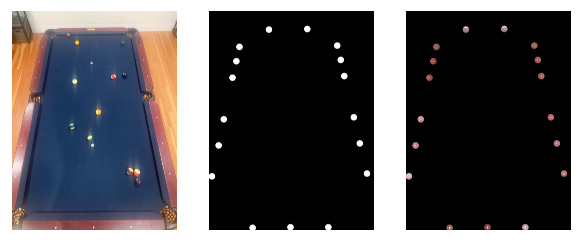

In [709]:
# Build a mask using a circle around each marker
imageInput = imageOriginal
imageMarkerMask = np.zeros(imageInput.shape[:2], np.uint8)

circleMaskRadius = 60
clrWhite = (255,255,255)
for marker in markers:
    cv.circle(imageMarkerMask, marker, circleMaskRadius, clrWhite, -1)
    
# Apply the mask to the image
imageMarkers = cv.bitwise_and(imageInput, imageInput, mask=imageMarkerMask)
    
ImgShow([imageOriginal, imageMarkerMask, imageMarkers])

imageInput.shape = (4032, 3024, 3)
markerPoints count = 17


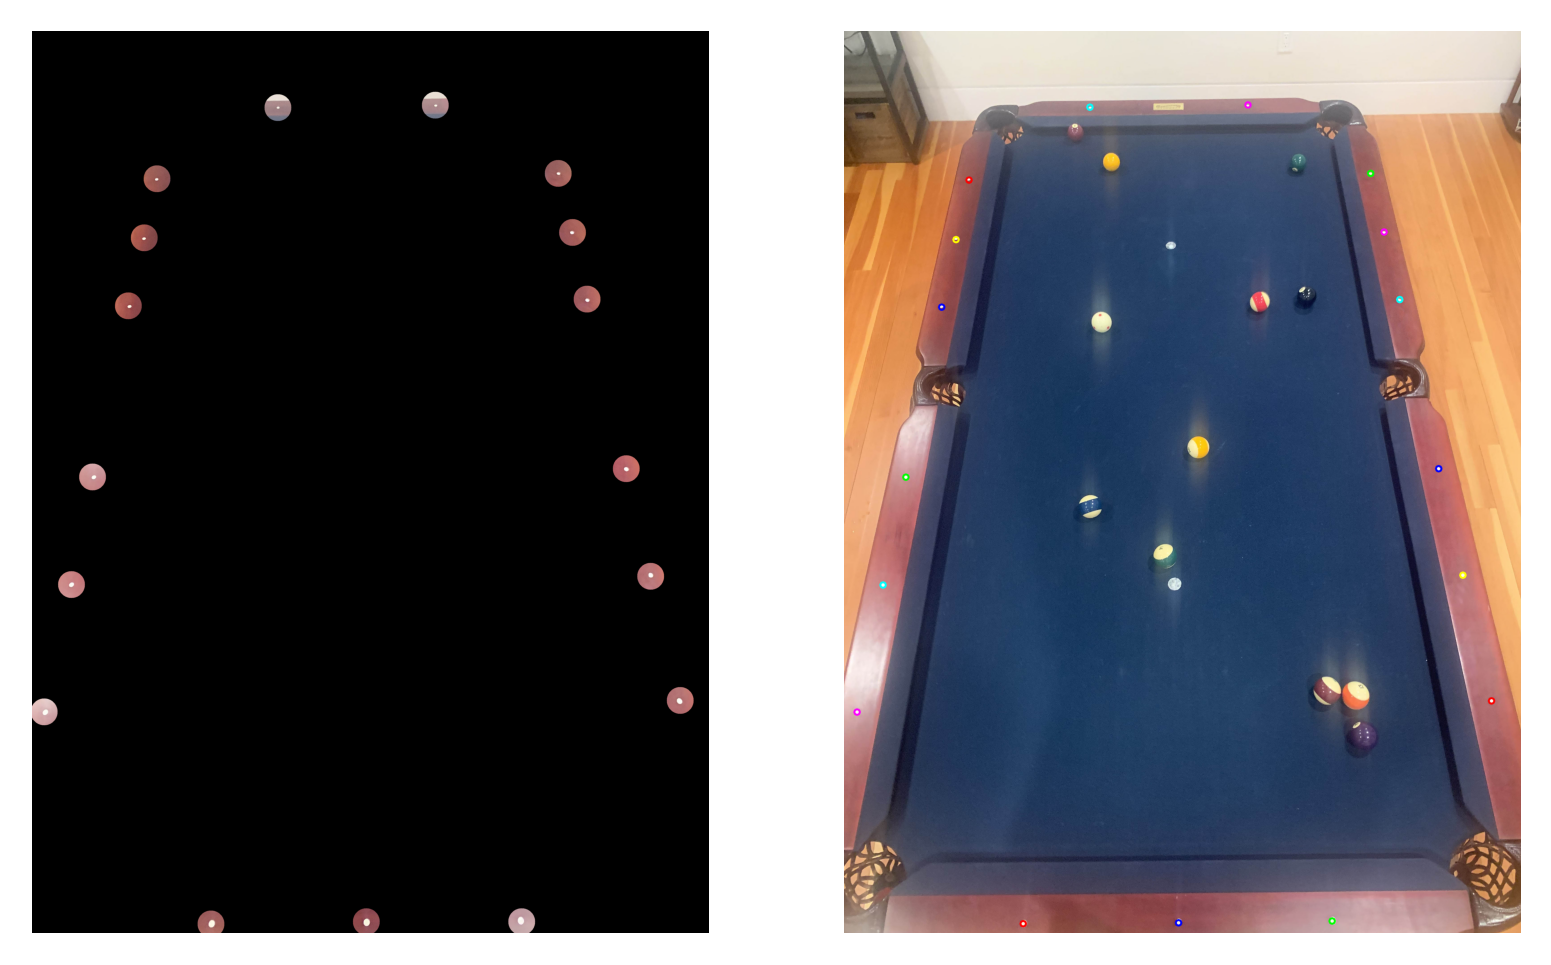

In [710]:
# Hough Circles. 
imageInput = imageMarkers
print("imageInput.shape = {0}".format(imageInput.shape))

# Limit by size range and distance
cols = imageInput.shape[1]
rows = imageInput.shape[0]
imageGray = cv.cvtColor(imageInput, cv.COLOR_BGR2GRAY)
imageGray = cv.medianBlur(imageGray, 5)
hcircles = cv.HoughCircles(imageGray, cv.HOUGH_GRADIENT, minDist=100, dp=1,
                               param1=100, param2=10,
                               minRadius=5, maxRadius=35)

# Create an array of points
markerPoints = []
imageCircles = imageOriginal.copy()
if hcircles is not None:
    hcircles = np.uint16(np.around(hcircles))
    for i in hcircles[0, :]: 
        pt = (i[0], i[1])
    
        # Filter out points ouside of image
        if pt[0] < 0 or pt[1] < 0:
            continue
        if pt[0] > cols-1 or pt[1] > rows-1:
            continue
    
        markerPoints.append(pt)
        cv.circle(imageCircles, pt, 12, Color(), 7)
        
print("markerPoints count = {0}".format(len(markerPoints)))
    
ImgShow([imageInput, imageCircles], 320)

color range = (204, 204, 204) - (256, 256, 256)
Prunage: 17 - 17


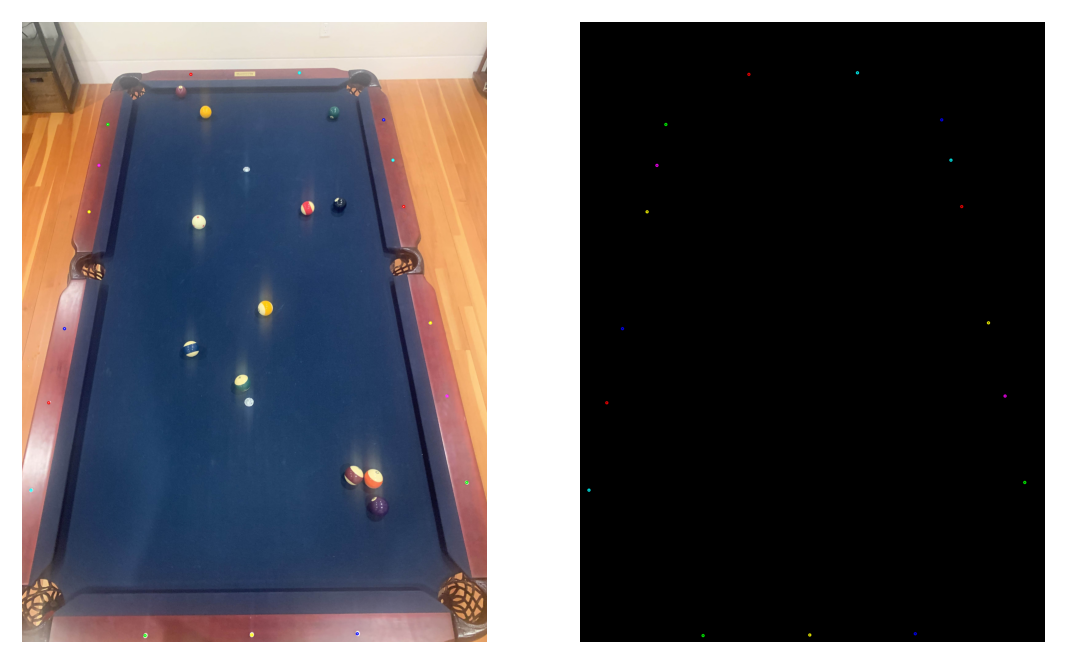

In [711]:
# Filter out circles that don't match the color we want
# We will assume that the circle centers should be whiteish

# Find the range
clrWhite = (240, 240, 240)
fuzz = 35

imageCirclesWhite = imageOriginal.copy()
imageCirclesWhiteBlack = np.zeros(imageOriginal.shape[:3],np.uint8)

clrMin, clrMax = ColorRange(clrWhite, fuzz)
clrMin = (clrMin[0]-1,clrMin[1]-1,clrMin[2]-1,)
clrMax = (clrMax[0]+1,clrMax[1]+1,clrMax[2]+1,)
print("color range = {0} - {1}".format(clrMin, clrMax))
circlesWhite = []
for pt in markerPoints:
    
    clr = imageOriginal[pt[1],pt[0]]
    if (clr > clrMin).all() and (clr < clrMax).all():
        circlesWhite.append(c)
        clr = Color()
        cv.circle(imageCirclesWhite, pt, c.radius(), clr, 6)
        cv.circle(imageCirclesWhiteBlack, pt, c.radius(), clr, 6)
        #print("pt={0} clr={1}".format(pt, clr))
print("Prunage: {0} - {1}".format(len(markerPoints), len(circlesWhite)))

ImgShow([imageCirclesWhite, imageCirclesWhiteBlack], 220)

In [712]:
# Group the markers into lines

# Find the top and bottom points by scanning all points
ymin = 10E10
ymax = 0
for pt in markerPoints:
    if pt[1] < ymin:
        ymin = pt[1]
    if pt[1] > ymax:
        ymax = pt[1]

# Sort the markers
markersL = []
markersR = []
markersT = []
markersB = []

yFuzz = int(imageOriginal.shape[0] / 20)    # search range
xmid = int(imageOriginal.shape[1] / 2)
for pt in markerPoints:
    if pt[1] < ymin + yFuzz:
        markersT.append(pt)
    else:
        if pt[1] > ymax - yFuzz:
            markersB.append(pt)
        else:
            if pt[0] < xmid:
                markersL.append(pt)
            else:
                markersR.append(pt)

# Sort by position, not sure this is necessary
markersL.sort(key = lambda circ: circ[1])
markersR.sort(key = lambda circ: circ[1])
markersT.sort(key = lambda circ: circ[0])
markersB.sort(key = lambda circ: circ[0])

print("markersL count={0}".format(len(markersL)))
print("markersR count={0}".format(len(markersR)))
print("markersT count={0}".format(len(markersT)))
print("markersB count={0}".format(len(markersB)))



markersL count=6
markersR count=6
markersT count=2
markersB count=3


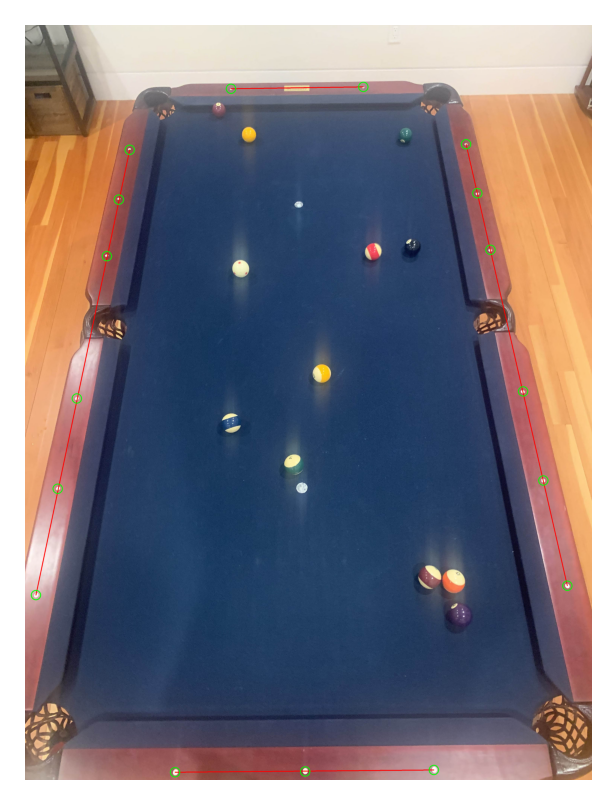

In [718]:
# Show on an image just for sanity
imageMarkerLines = imageOriginal.copy()

clrLine = (0,0,255)
clrMark = (0,255,0)
def Draw(mks):
    pt1 = mks[0]
    pt2 = mks[len(mks) - 1]
    cv.line(imageMarkerLines, pt1, pt2, clrLine, 4)
    for pt in mks:
        cv.circle(imageMarkerLines, pt, 25, clrMark, 4)
        
Draw(markersL)
Draw(markersR)
Draw(markersT)
Draw(markersB)
    
ImgShow([imageMarkerLines], 250)